# Imports

In [9]:
import sys
import os
from pathlib import Path

current_dir = os.getcwd()

file = Path(current_dir).resolve()
sys.path.append(str(file.parents[0]))

In [10]:
from data.bids_dataset import BidsDataset
from skimage.measure import block_reduce
from argparse import Namespace
import torch
from utils.brats_tools import plot_slices, get_central_slice, get_central_slice_from_tensor
import numpy as np

In [11]:
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge'

# Manual Application of Downsampling

## Creation of Bids Dataset and obtaining Samples

In [5]:
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.125, do2D = False, soft=False, dilate=0, binary=True, ds_factor=None)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [63]:
idx = 10
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

### Looking at shapes, dtypes and ranges

In [64]:
print(f"img shape {sample_img.shape}")
print(f"gt shape {sample_gt.shape}")
print(f"soft gt shape {sample_soft_gt.shape}")

img shape torch.Size([4, 152, 192, 144])
gt shape torch.Size([1, 152, 192, 144])
soft gt shape torch.Size([2, 152, 192, 144])


In [65]:
print(f"img dtype {sample_img.dtype}")
print(f"gt dtype {sample_gt.dtype}")
print(f"soft gt dtype {sample_soft_gt.dtype}")

img dtype torch.float32
gt dtype torch.int64
soft gt dtype torch.float32


In [66]:
print(f"img values range {torch.unique(sample_img)}")
print(f"gt values range {torch.unique(sample_gt)}")
print(f"soft gt values range {torch.unique(sample_soft_gt)}")

img values range tensor([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
        11., 12., 13., 14.])
gt values range tensor([0, 1])
soft gt values range tensor([0.0000e+00, 2.0305e-42, 4.0624e-42, 6.0928e-42, 1.6038e-28, 3.2076e-28,
        4.8114e-28, 6.4152e-28, 8.0191e-28, 9.6229e-28, 1.2664e-14, 2.5328e-14,
        3.7992e-14, 5.0657e-14, 6.3321e-14, 7.5985e-14, 1.0000e+00])


In [67]:
# Step 1: Flatten the img to a 1D array for easier processing
flat_img = sample_img.flatten()

# Step 2: Find unique sum values and their counts
unique_sums, counts = torch.unique(flat_img, return_counts=True)

print(f"Image Values and frequency")
print(unique_sums)
print(counts)

Image Values and frequency
metatensor([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
        11., 12., 13., 14.])
metatensor([    2422,   131280,   616342, 15340642,   535129,    98156,    71459,
            5998,     4454,     2531,     1021,      292,      132,       63,
              27,       27,        7,        2])


## Plotting slices of samples

### Hard GTs

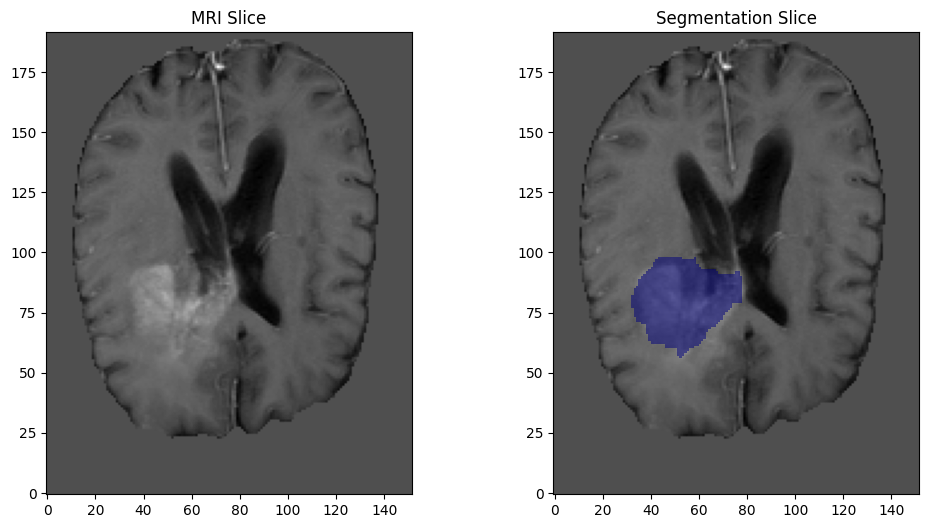

In [30]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))

### Soft GTs

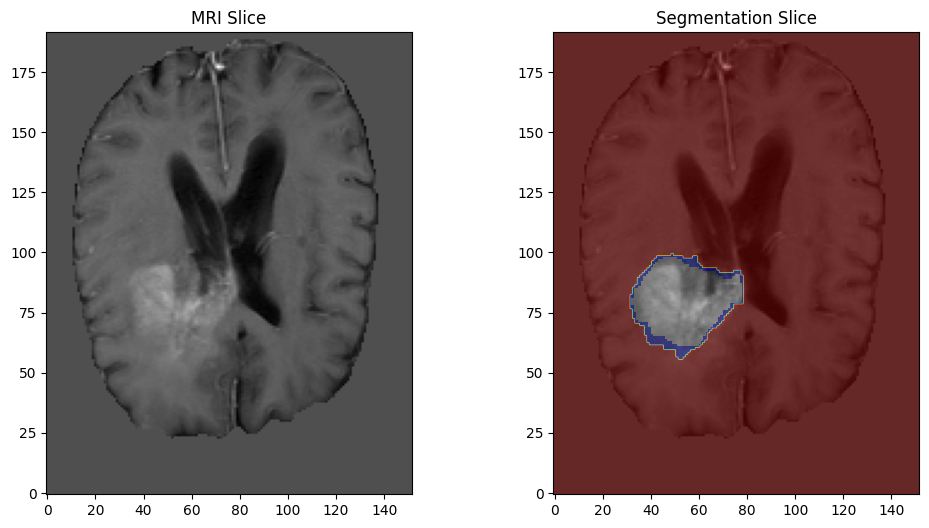

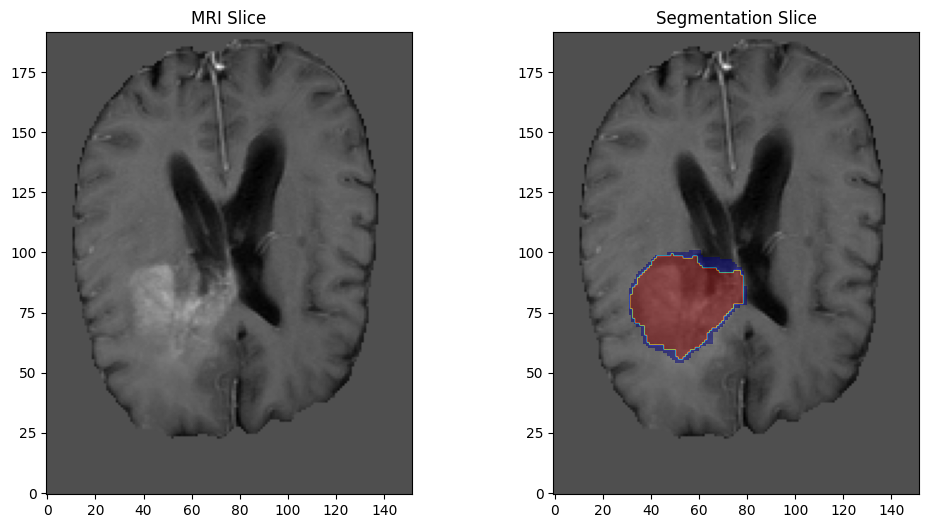

In [31]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))

## Applying Downsampling on Samples

In [101]:
ds_factor = 2

### Downsampling on img and gt and rebinarization of hard gt

#### Using Numpy

In [102]:
oh_gt = torch.nn.functional.one_hot(sample_gt.squeeze(0), num_classes=2).permute(3,0,1,2)

In [103]:
print(f"img values range {torch.unique(sample_img)}")
print(f"gt values range {torch.unique(sample_gt)}")
print(f"soft gt values range {torch.unique(sample_soft_gt)}")

img values range tensor([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
        11., 12., 13., 14.])
gt values range tensor([0, 1])
soft gt values range tensor([0.0000e+00, 2.0305e-42, 4.0624e-42, 6.0928e-42, 1.6038e-28, 3.2076e-28,
        4.8114e-28, 6.4152e-28, 8.0191e-28, 9.6229e-28, 1.2664e-14, 2.5328e-14,
        3.7992e-14, 5.0657e-14, 6.3321e-14, 7.5985e-14, 1.0000e+00])


In [104]:
down_img = block_reduce(np.array(sample_img), block_size= (1, ds_factor, ds_factor, ds_factor), func = np.mean)
down_gt = block_reduce(np.array(oh_gt), block_size=(1, ds_factor, ds_factor, ds_factor) ,func = np.mean)

In [105]:
print(f"down img values range {np.unique(down_img)}")
print(f"down gt value range {np.unique(down_gt)}")

down img values range [-2.5   -2.25  -2.125 -2.    -1.875 -1.75  -1.625 -1.5   -1.375 -1.25
 -1.125 -1.    -0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125  0.
  0.125  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.125  1.25
  1.375  1.5    1.625  1.75   1.875  2.     2.125  2.25   2.375  2.5
  2.625  2.75   2.875  3.     3.125  3.25   3.375  3.5    3.625  3.75
  3.875  4.     4.125  4.25   4.375  4.5    4.625  4.75   4.875  5.
  5.125  5.25   5.375  5.5    5.625  5.75   5.875  6.     6.125  6.25
  6.375  6.5    6.625  6.75   6.875  7.     7.125  7.25   7.375  7.5
  7.625  7.75   7.875  8.     8.125  8.25   8.375  8.5    8.625  9.875
 10.75  11.   ]
down gt value range [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]


In [116]:
img_tensor = torch.tensor(down_img).float()
soft_gt_tensor = torch.tensor(down_gt).float()
gt_tensor = torch.argmax(torch.round(soft_gt_tensor).long(), dim=0).unsqueeze(0)

In [117]:
print(f"shape of img_tensor: {img_tensor.shape}")
print(f"shape of gt_tensor: {gt_tensor.shape}")
print(f"shape of soft_gt_tensor: {soft_gt_tensor.shape}")

shape of img_tensor: torch.Size([4, 76, 96, 72])
shape of gt_tensor: torch.Size([1, 76, 96, 72])
shape of soft_gt_tensor: torch.Size([2, 76, 96, 72])


In [118]:
print(f"dtype of img_tensor: {img_tensor.dtype}")
print(f"dtype of gt_tensor: {gt_tensor.dtype}")
print(f"dtype of soft_gt_tensor: {soft_gt_tensor.dtype}")

dtype of img_tensor: torch.float32
dtype of gt_tensor: torch.int64
dtype of soft_gt_tensor: torch.float32


#### Using Torch

In [114]:
down_img = block_reduce(sample_img, block_size= (1, ds_factor, ds_factor, ds_factor), func = torch.mean)
down_gt = block_reduce(oh_gt, block_size=(1, ds_factor, ds_factor, ds_factor) ,func = torch.mean)

AttributeError: 'MetaTensor' object has no attribute 'strides'

### Checking if sums across channels are 1

#### Torch

In [108]:
# Step 1: Sum across channels (dim=0)
sum_across_channels = soft_gt_tensor.sum(dim=0)

# Step 2: Flatten the summed values to a 1D array for easier processing
flat_sums = sum_across_channels.flatten()

# Step 3: Find unique sum values and their counts
unique_sums, counts = torch.unique(flat_sums, return_counts=True)

In [109]:
#print(sum_across_channels)
#print(flat_sums)
print(unique_sums)
print(counts)

tensor([1.], dtype=torch.float64)
tensor([525312])


#### Numpy

In [110]:
sum_across_channels = np.array(soft_gt_tensor.sum(dim=0))
flat_sums = sum_across_channels.flatten()
unique_sums, counts = np.unique(flat_sums, return_counts=True)

In [111]:
#print(sum_across_channels)
#print(flat_sums)
print(unique_sums)
print(counts)

[1.]
[525312]


### Plotting of Downsampled img, gt and soft gt

#### Hard GTs

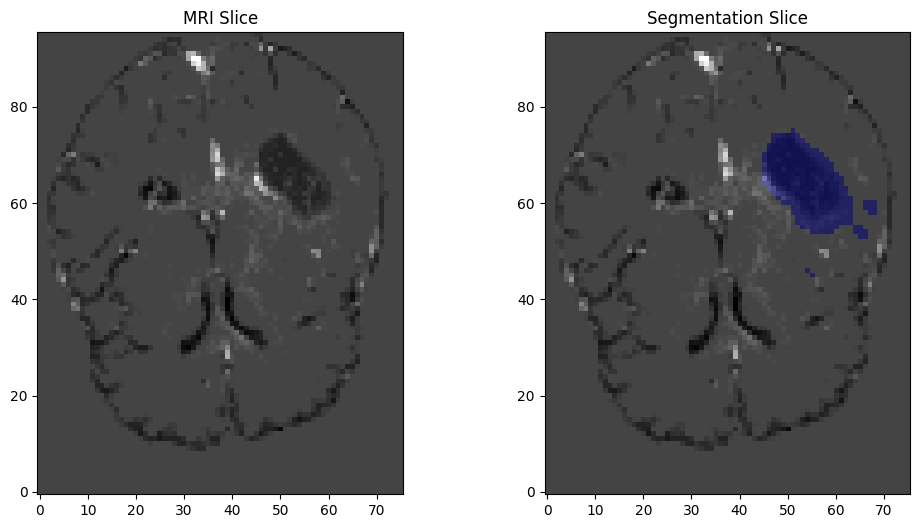

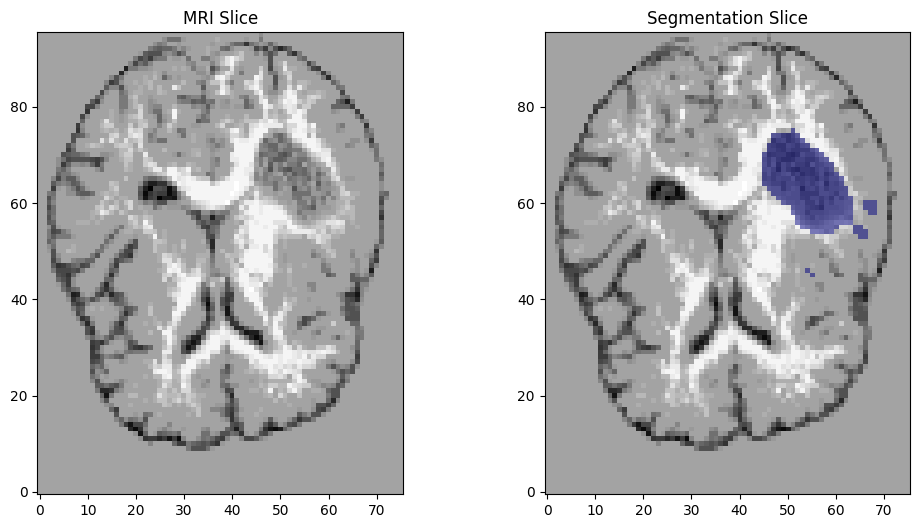

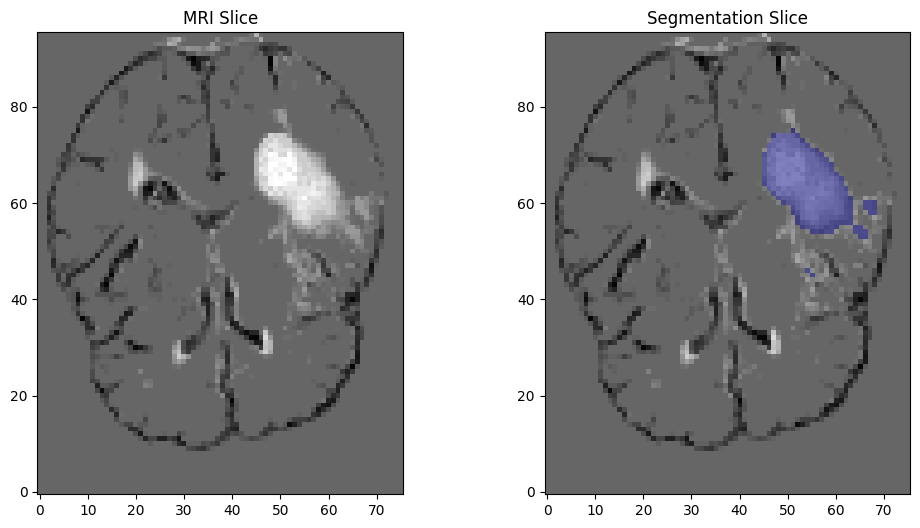

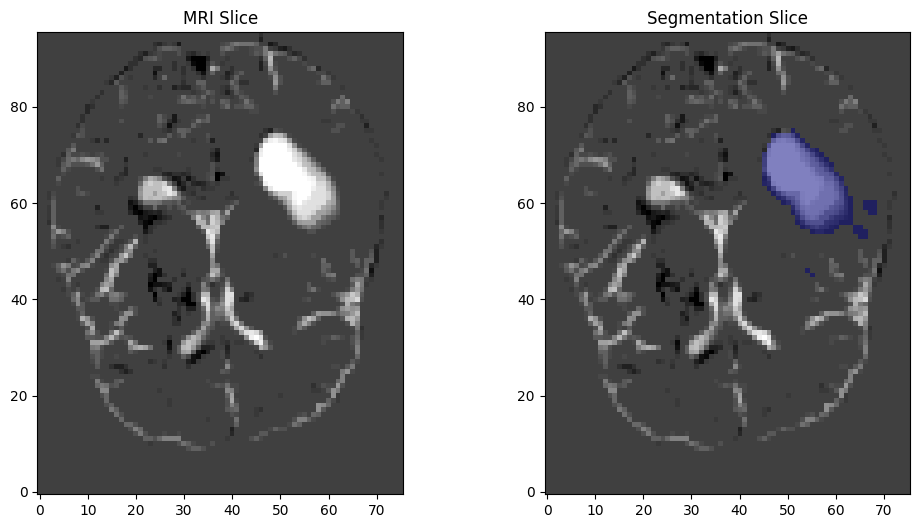

In [112]:
axis = 2
plot_slices(get_central_slice(img_tensor[0], axis), get_central_slice(gt_tensor, axis))
plot_slices(get_central_slice(img_tensor[1], axis), get_central_slice(gt_tensor, axis))
plot_slices(get_central_slice(img_tensor[2], axis), get_central_slice(gt_tensor, axis))
plot_slices(get_central_slice(img_tensor[3], axis), get_central_slice(gt_tensor, axis))

#### Soft GTs

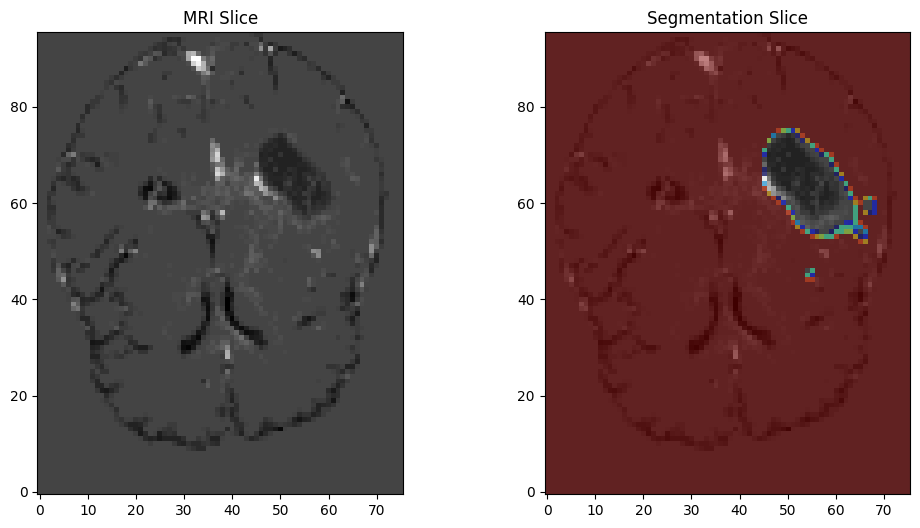

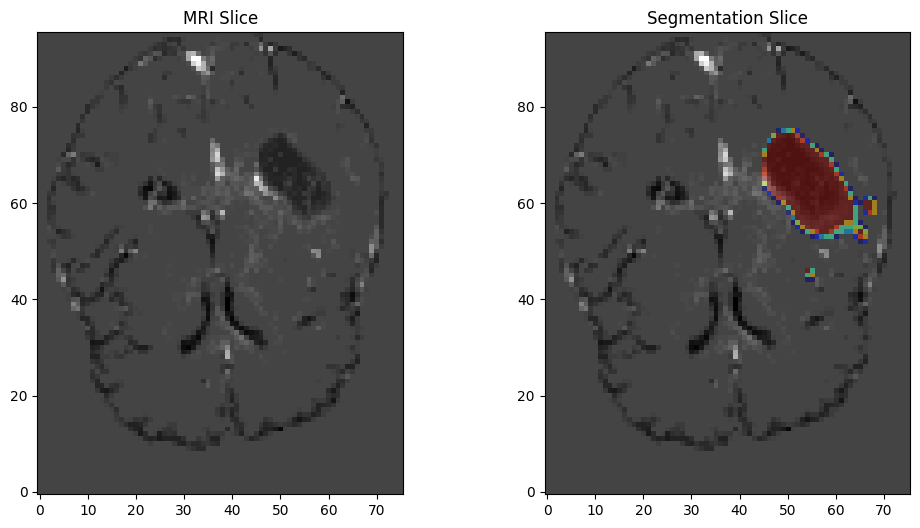

In [113]:
axis = 2
plot_slices(get_central_slice(img_tensor[0], axis), get_central_slice(soft_gt_tensor[0], axis))
plot_slices(get_central_slice(img_tensor[0], axis), get_central_slice(soft_gt_tensor[1], axis))

# Downsampling innerhalb BidsDataset

In [14]:
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.125, do2D = False, soft=False, dilate=0, binary=True, ds_factor=2)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [15]:
idx = 10
sample = bids_ds[idx]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

RuntimeError: applying transform <monai.transforms.croppad.dictionary.ResizeWithPadOrCropd object at 0x73808f3b3b10>